## Gender Classification with Logistic Regression using First Names

In [111]:
# import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [112]:
# Read the dataset
df = pd.read_csv("../assets/data/gender.csv")

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    1294 non-null   object
 1   Target  1294 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.3+ KB


In [114]:
df.head()

,Name,Target
0,Yash,1
1,Prit,1
2,Meet,1
3,Drashti,0
4,Saloni,0


In [115]:
# Converting all names to lowercase
df['Name'] = df['Name'].str.lower()
df.head()

,Name,Target
0,yash,1
1,prit,1
2,meet,1
3,drashti,0
4,saloni,0


In [116]:
# Convert each name to feature vector
X = []
y = []

# Considering the last character and bigrams in name
num_feats = 702    # 26 letters + 26*26 bigrams = 702 features

for i in range(len(df)):
  name = df.iloc[i]['Name']
  target = df.iloc[i]['Target']

  vec = np.zeros(num_feats)

  # Consider last character
  key = name[-1]
  if (ord(key) < 97 or ord(key) > 122):
    continue
  vec[ord(key)-97] +=1

  # Consider all bigrams
  for i in range(len(name)-1):
    bigram = name[i:i+2]
    # Skipping whitespace and extra characters if any
    if (ord(bigram[0]) < 97 or ord(bigram[0]) > 122 or ord(bigram[1]) < 97 or ord(bigram[1]) > 122):
      continue
    vec[26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)] += 1

  vec = vec.reshape(-1, 1)
  X.append(vec)

  if target == 0:
    # 0 represents girl
    y.append(0)
  else:
    # 1 represents boy
    y.append(1)

# Printing sample feature vector and label
print(X[0].shape)
print(y[0])

(702, 1)
1


In [117]:
# Split data into train, val and test sets
test_size = 0.1
val_size = 0.1

data = list(zip(X, y))

split_index1 = int(len(data) * (1 - test_size - val_size))
split_index2 = int(len(data) * (1 - test_size))
train_data = data[:split_index1]
val_data = data[split_index1:split_index2]
test_data = data[split_index2:]

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)
X_val, y_val = zip(*val_data)

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)
X_val, y_val = np.array(X_val), np.array(y_val)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

print(f'Number of training examples: {len(X_train)}')
print(f'Number of validation examples: {len(X_val)}')
print(f'Number of test examples: {len(X_test)}')

Number of training examples: 1034
Number of validation examples: 129
Number of test examples: 130


In [118]:
# Computes the sigmoid function
def sigmoid(z):
    return (1.0 / (1 + np.exp(-z)))

In [119]:
# Computes a forward pass
def forward(X, W, b):
    z = sigmoid(np.dot(X, W) + b)
    return (z > 0.5).astype(int)

In [120]:
# Computes the binary cross-entropy loss
def loss(y, y_hat):
    epsilon = 1e-10
    return -np.sum(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))

In [121]:
# Trains the logistic regression model using gradient descent
def train(X, y, W, b, learning_rate=0.5, num_iterations=100000):
    X = np.squeeze(X)
    m = X.shape[0]
    losses = []

    for i in range(num_iterations):
        z = np.dot(X, W) + b
        a = sigmoid(z)
        losses.append(loss(y, a))
        if (i % 1000 == 0):
            print("Loss at iteration", i, "is", loss(y, a))
        dz = a - y
        dW = (1 / m) * np.dot(dz.T, X)
        db = (1 / m) * np.sum(dz)
        W = W - (learning_rate*(dW.T))
        b = b - (learning_rate * db)
    
    return W, b, losses


In [122]:
# Computes the accuracy of the model
def get_accuracy(X, y, W, b):
    X = np.squeeze(X)
    m = X.shape[0]
    print(f"Total number of samples: {m}")

    Z = forward(X, W, b)
    equal_elements = np.sum(Z == y)
    print(f"Number of correct predictions: {equal_elements}")
    return equal_elements/m

In [123]:
# Computes the confusion matrix for the model
def confusion_matrix(X, y, W, b):
    X = np.squeeze(X)
    m = X.shape[0]

    Z = forward(X, W, b)

    cf = [[0, 0], [0, 0]]
    
    for i in range(len(Z)):
        if Z[i] == 0 and y[i] == 0:
            cf[0][0] += 1
        elif Z[i] == 0 and y[i] == 1:
            cf[0][1] += 1
        elif Z[i] == 1 and y[i] == 0:
            cf[1][0] += 1
        elif Z[i] == 1 and y[i] == 1:
            cf[1][1] += 1

    return cf

In [124]:
# Defining weights and bias
W = np.zeros((num_feats, 1))
b = 0

In [125]:
# Tuning hyperparameters using validation set
W, b, losses = train(X_train, y_train, W, b, 0.5, 10000)

val_accuracy = get_accuracy(X_val, y_val, W, b)
print(f"Accuracy on validation set: {val_accuracy}")

# Reset parameters for changing hyperparameters and tuning again
W = np.zeros((num_feats, 1))
b = 0

Loss at iteration 0 is 716.7141844921834
Loss at iteration 1000 is 251.61336894449173
Loss at iteration 2000 is 220.88252083177596
Loss at iteration 3000 is 203.9522246644123
Loss at iteration 4000 is 192.47262740680617
Loss at iteration 5000 is 183.9164297136569
Loss at iteration 6000 is 177.17547953808662
Loss at iteration 7000 is 171.6662449936556
Loss at iteration 8000 is 167.04368601827787
Loss at iteration 9000 is 163.0864874650701
Total number of samples: 129
Number of correct predictions: 112
Accuracy on validation set: 0.8682170542635659


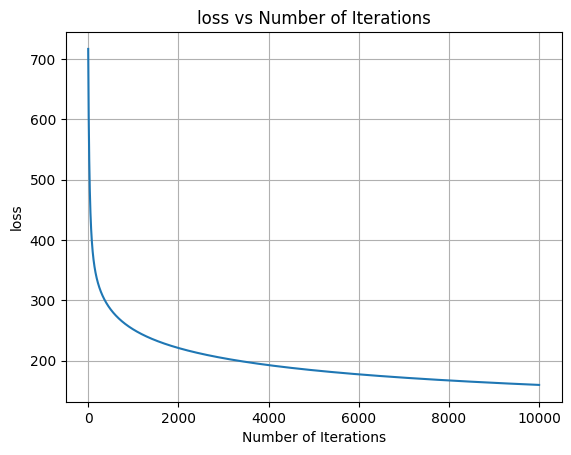

In [126]:
# Plotting missclassifications against the number of iterations
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Number of Iterations')
plt.ylabel('loss')
plt.title('loss vs Number of Iterations')
plt.grid(True)
plt.show()

In [127]:
# Training on both train and validation dataset
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))
W, b, losses = train(X_train_val, y_train_val, W, b, 0.5, 10000)

Loss at iteration 0 is 806.1301707586163
Loss at iteration 1000 is 287.16182470754575
Loss at iteration 2000 is 256.3197660211328
Loss at iteration 3000 is 239.7500714653495
Loss at iteration 4000 is 228.7100038123874
Loss at iteration 5000 is 220.61107399121153
Loss at iteration 6000 is 214.32329354910473
Loss at iteration 7000 is 209.25245751192188
Loss at iteration 8000 is 205.0490545675553
Loss at iteration 9000 is 201.49076642072217


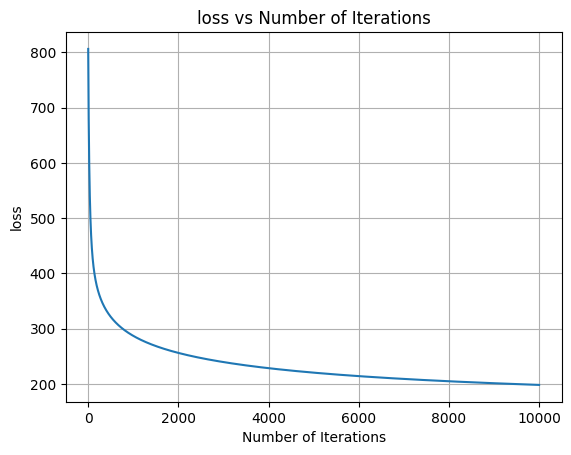

In [128]:
# Plotting missclassifications against the number of iterations
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Number of Iterations')
plt.ylabel('loss')
plt.title('loss vs Number of Iterations')
plt.grid(True)
plt.show()

In [129]:
accuracy = get_accuracy(X_test, y_test, W, b)
print(f"Accuracy on test set: {accuracy}")

Total number of samples: 130
Number of correct predictions: 117
Accuracy on test set: 0.9


In [130]:
cf = confusion_matrix(X_test, y_test, W, b)
print(cf)

[[80, 5], [8, 37]]


In [131]:
def predict(test_name):
    # Convert name to feature vector
    name = test_name.lower()

    vec = np.zeros(num_feats)

    # Consider last character of name
    vec[ord(name[-1]) - 97] += 1

    # Consider all bigrams
    for i in range(len(name)-1):
        bigram = name[i:i+2]
        if (ord(bigram[0]) < 97 or ord(bigram[0]) > 122 or ord(bigram[0]) < 97 or ord(bigram[1]) > 122):
            continue
        vec[26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)] += 1

    # vec = vec.reshape(-1, 1)

    z = forward(vec, W, b)

    if z == 1:
        print("I am sure " + test_name + " is a boy.")
    elif z == 0:
        print("I am sure " + test_name + " is a girl.")

In [132]:
# Testing with our own example
predict("Preet")
predict("Preeti")

I am sure Preet is a boy.
I am sure Preeti is a girl.


In [133]:
# Verifying implementation using scikit learn
from sklearn.linear_model import LogisticRegression

# Removing the extra dimension
X_train_val = np.squeeze(X_train_val)
y_train_val = np.squeeze(y_train_val)
X_test = np.squeeze(X_test)
y_test = np.squeeze(y_test)

# Initialize the Linear Regression model
model = LogisticRegression()
model.fit(X_train_val, y_train_val)

# Evaluate the model
accuracy = model.score(X_test, y_test)

print("Accuracy using scikit learn:", accuracy)

Accuracy using scikit learn: 0.8923076923076924
